# Ornstein-Uhlenbeck Pair Trading

### Libraries

In [ ]:
!pip install alpaca-py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from math import gamma
from scipy.optimize import root_scalar
import seaborn as sns
import yfinance as yf
from itertools import combinations
import pandas as pd

from alpaca.data.historical.stock import StockBarsRequest,StockHistoricalDataClient
from alpaca.data.historical.crypto import CryptoBarsRequest,CryptoHistoricalDataClient
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest,OrderSide,TimeInForce,GetAssetsRequest,AssetClass
from alpaca.data.live import StockDataStream,CryptoDataStream
from datetime import datetime

%matplotlib inline

## Methodology and Analysis

Optimal Mean Reversion Trading: Mathematical Analysis And Practical Applications by Tim Siu-tang Leung, Xin Li

Video:  <a href = "https://youtu.be/vHzlZECzyPE">What is a pairs trade</A><br>
Video:  <a href="https://youtu.be/GdqVY1kZ4XI">Maximum Likelihood Estimation with Ornstein-Uhlenbeck (part 1)</A><br>
Video:  <a href="https://youtu.be/3906CWKhLqQ">Maximum Likelihood Estimation with Ornstein-Uhlenbeck (part 2)</A><br>

### Ornstein-Uhlenbeck Process and Parameter Determination

$$ dX_t = \mu(\theta - X_t) dt + \sigma dW_t$$


When we wish to simulate this process, we use a differencing formula:
$$X_i - x_{i-1} = \mu(\theta - X_i) (t_i - t_{i-1}) + \sigma\sqrt{t_i - t_{i-1}}W_t$$

The optimal parameters can be calculated analytically.

First define

$$
X_x = \sum_{i=1}^N x_{i-1}
$$

$$
X_y = \sum_{i=1}^N x_i
$$

$$
X_{xx} = \sum_{i=1}^N (x_{i-1})^2
$$

$$
X_{xy} = \sum_{i=1}^N x_{i-1} x_i
$$

$$
X_{yy} = \sum_{i=1}^N (x_i)^2
$$

The optimal parameters are given by,


$$
\mu^* = \frac{X_y X_{xx} - X_x X_{xy}}
{N(X_{xx} - X_{xy}) - (X_x^2 - X_xX_y)}
$$

$$
\theta^* = -\frac{1}{\Delta t} \ln\left(
\frac{X_{xy} - \mu^*X_x - \mu^*X_y + N(\mu^*)^2}
{X_{xx} - 2\mu^*X_x + N(\mu^*)^2}\right)
$$

$$
\begin{multline}
(\sigma^*)^2 = \frac{2\theta^*}{N(1-e^{-2\theta^*\Delta t})} (X_{yy} - 2e^{-\theta^*\Delta t} X_{xy} + e^{-2\theta^*\Delta t}X_{xx}
- 2\mu^* (1-e^{-\theta^*\Delta t})(X_y - e^{-\theta^*\Delta t})X_x + N(\mu^*)^2(1-e^{-\theta^*\Delta t})^2)
\end{multline}
$$

In [ ]:
def log_likelihood( parameters, S, dt ):
    theta = parameters[0]
    mu = parameters[1]
    sigma = parameters[2]

    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt( sigma0 )

    N = S.size

    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma0)

    prefactor = -1 / (2 * N * sigma0**2)
    sum_term = 0
    for i in range( 1, N ):
        x2 = S[i]
        x1 = S[i-1]

        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) - \
                   theta * (1-np.exp(-mu*dt)))**2

    f = (term1 + term2 + prefactor * sum_term)

    return f

def calculate_parameters(x, dt):

    N =x.size

    Xx  = np.sum(x[0:-1])
    Xy  = np.sum(x[1:])
    Xxx = np.sum(x[0:-1]**2)
    Xxy = np.sum(x[0:-1] * x[1:])
    Xyy = np.sum(x[1:]**2)

    mu = (Xy * Xxx - Xx * Xxy) / (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy) )

    theta = (Xxy - mu * Xx - mu * Xy + N * mu**2) / \
        (Xxx - 2 * mu * Xx + N * mu**2)

    theta = max(theta, 1e-10) # avoid negative theta in log
    theta = -1 / dt * np.log(theta)

    prefactor = 2 * theta / (N*(1-np.exp(-2*theta*dt)))
    term = Xyy - 2*np.exp(-theta*dt) * Xxy + np.exp(-2*theta*dt) * Xxx - 2*mu*(1-np.exp(-theta*dt)) * (Xy - Xx * np.exp(-theta*dt)) + N * mu**2 * ( 1-np.exp(-theta * dt))**2

    sigma02 = prefactor * term

    sigma02 = max(sigma02, 1e-10) # avoid 0 and negative sigma
    sigma = np.sqrt(sigma02)

    return mu, theta, sigma

###  Pairs Price


Our $X$ values will be the price of the pair over some range of time.

$$
X^{\alpha, \beta}_t = \alpha S_t^{(1)} - \beta S_t^{(2)}
$$

where $S_t^{(1)}$ and $S_t^{(2)}$ are the prices of stock one and two, respectively.  Likewise, $\alpha$ and $\beta$ are the numbers of shares of $S^{(1)}$ and $S^{(2)}$ owned.

For each potential pair, in other words for different values of $\alpha$ and $\beta$, we will use historical data to generate the OU parameters.

We will then sweep the values for $\alpha$ and $\beta$ (actually the ratio) and find the values that maximize the log likelihood.  We fix $\alpha$ and sweep $\beta$.

If we put $A$ dollars in $S^{(1)}$ we have
$$
\alpha = \frac{A}{S_0^{(1)}}.
$$

$$
\beta = \frac{B}{S_0^{(2)}}.
$$

The authors do the calculation in dollar amounts.  Since we only care about a ratio, we can set $A=1$.  When w do the calculation, we can sweep the parameters by taking a range of the ratio $B/A$.  We will take $B/A = 0.001 \ldots 1$.

###  Example



Our pairs will be GLD-GDX, and GLD-SLV.

Let's load in the GLD, GDX, and SLV data.

In [ ]:
# Define the tickers and the date range
tickers = ['GLD', 'GDX', 'SLV']
start_date = '2010-01-01'
end_date = '2013-12-31'

# Fetch data from Yahoo Finance
data = {ticker: yf.download(ticker, start=start_date, end=end_date)['Close'] for ticker in tickers}

# Convert data to numpy arrays
price_data = {ticker: data[ticker].to_numpy() for ticker in tickers}

# Print the number of data points for each ticker
for ticker in tickers:
    print(f'Number of data points for {ticker}: {price_data[ticker].size}')

# Calculate dt (daily change, assuming 252 trading days per year)
dt = 1 / 252

NameError: name 'yf' is not defined

Example is based on grid search of the best pair and beta for the biggest likelihood of spread

In [ ]:
#B/A Ratios to Test
B_over_A = np.linspace(0.001, 1, 1000)

#likelihood and param dictionaries
results = {}

#calc Optimal B and params each pair
for i, ticker_1 in enumerate(tickers):
    for j, ticker_2 in enumerate(tickers):
        if i < j:  # Avoid duplicates or self-pairs
            pair_key = f"{ticker_1}-{ticker_2}"
            likelihoods = []

            #Calculate likelihood for each B/A ratio
            for value in B_over_A:
                alpha = 1 / price_data[ticker_1][0] #calculate the weight of the first asset
                beta = value / price_data[ticker_2][0] #weight of second asset
                spread = alpha * price_data[ticker_1] - beta * price_data[ticker_2] #spread claculation
                parameters = calculate_parameters(spread, dt) # get the ou paprams - theta , mu sigma
                likelihood = log_likelihood(parameters, spread, dt)

                likelihoods.append(likelihood)

            # Find the optimal B for this pair

            max_likelihood = np.amax(likelihoods)
            ind = np.where(likelihoods == max_likelihood)[0] #get index of max likl

            optimal_B = B_over_A[ind][0] # get corresponding beta value

            # Recalculate parameters for the optimal B
            alpha = 1 / price_data[ticker_1][0]
            beta = optimal_B / price_data[ticker_2][0]
            spread = alpha * price_data[ticker_1] - beta * price_data[ticker_2]
            theta, mu, sigma = calculate_parameters(spread, dt)

            # Store results
            results[pair_key] = {
                "Optimal B": optimal_B,
                "Theta": theta,
                "Mu": mu,
                "Sigma": sigma,
                "Max Log Likelihood": max_likelihood,
            }


In [ ]:
# Display Results
for pair, params in results.items():
    print(f"\nPair: {pair}")
    print(f"Optimal B: {params['Optimal B']:.4f}")
    print(f"Theta (speed of reversion): {params['Theta']:.4f}")
    print(f"Mu (long-term mean): {params['Mu']:.4f}")
    print(f"Sigma (volatility): {params['Sigma']:.4f}")
    print(f"Max Log Likelihood: {params['Max Log Likelihood']:.4f}")

### Solution for optimal trading

Formulas for OU solution:
$$F(x) = \int_{0}^{\infty}u^{\frac{r}{\mu}-1} e^{\sqrt{\frac{2\mu}{\sigma^2}}(x-\theta)u-\frac{u^2}{2}}du$$
$$G(x) = \int_{0}^{\infty}u^{\frac{r}{\mu}-1} e^{\sqrt{\frac{2\mu}{\sigma^2}}(\theta-x)u-\frac{u^2}{2}}du$$
$$F'(x)>0,F''(x)>0,G'(x)<0,G''(x)>0$$

In [ ]:
def F(x,r=0.05,mu=4,u=0.3,sigma=0.2,theta=0.07):
    return u**(r/mu-1)*np.exp(np.sqrt(2*mu/sigma**2) * (x - theta) * u - u**2/2)
def G(x,r=0.05,mu=4,u=0.3,sigma=0.2,theta=0.07):
    return u**(r/mu-1)*np.exp(np.sqrt(2*mu/sigma**2) * (theta - x) * u - u**2/2)

In [ ]:
x = np.linspace(-0.5,0.5,100)

In [ ]:
plt.plot(x,F(x))
plt.plot(x,G(x))

In [ ]:
kappa = 0
# x < kappa
x = -0.2
E_f = F(x)/F(kappa)
# x < kappa
x = 0.2
E_g = G(x)/G(kappa)
E_f,E_g

In [ ]:
def psi(x,r = 0.05,mu = 4,u = 0.3,sigma = 0.2,theta = 0.07):
    return F(x,r,mu,u,sigma,theta)/G(x,r,mu,u,sigma,theta)
def psi_inv(x,r = 0.05,mu = 4,u = 0.3,sigma = 0.2,theta = 0.07):
    return G(x,r,mu,u,sigma,theta)/F(x,r,mu,u,sigma,theta)

In [ ]:
x = np.linspace(-0.5,0.5,100)
plt.plot(x,psi(x))
plt.plot(x,psi_inv(x))

In [ ]:
def h(x,cost = 0.007):
    return x - cost

In [ ]:
x = 0
a = -0.5
b = 0.3

In [ ]:
F(-1e3),G(-1e3)

In [ ]:
h(a) * ( F(x)*G(b)- F(b)*G(x) ) / ( F(a)*G(b)- F(b)*G(a) ) + h(b) * ( F(a)*G(x)- F(x)*G(a) ) / ( F(a) * G(b)- F(b)*G(a) )

In [ ]:
def H(z):
    return h(psi_inv(z) / G(psi_inv(z)))

In [ ]:
cost = 0.007
psi(cost)

In [ ]:
z = np.linspace(0,3,100)
plt.plot(z,H(z))

NameError: name 'np' is not defined

In [ ]:
def simulate_ou(T = 1, N = 1000, theta = 1, mu = 0, sigma = 1, X0 = 0):
    dt = T/N
    X = [X0]
    for i in range(N):
        Z = np.random.normal(0,1)
        X.append(X[i] + theta * (mu- X[i]) * dt + sigma * np.sqrt(dt) * Z)
    time = np.linspace(0,T,N+1)
    return np.array(X),time

In [ ]:
X,time = simulate_ou()
plt.plot(time,X)

In [ ]:
def solve_for_a(c, N = 100):
    def lhs(a):
        s = [(np.sqrt(2 * a))**(2 * n + 1) / factorial(2 * n + 1) * gamma((2 * n + 1) / 2) for n in range(N)]
        return np.sum(s) / 2
    def rhs(a):
        s = [(np.sqrt(2 * a))**(2 * n) / factorial(2 * n) * gamma((2 * n + 1) / 2)  for n in range(N)]
        return np.sum(s) * np.sqrt(2 / np.pi) * (a- c / 2)
    def equation(a):
        return lhs(a) - rhs(a)
    res = root_scalar(equation,bracket=[1e-2,10],method='bisect')
    print(equation(res.root))
    return res.root

In [ ]:
c = 0.02
a_star = solve_for_a(c)

In [ ]:
a_star

In [ ]:
def make_signals(T = 1, N = 1000, theta = 1, mu = 0, sigma = 1, X0 = 0):
    X,time = simulate_ou(T,N,theta,mu,sigma,X0)
    u_threshold = mu + a_star * sigma / np.sqrt(2*theta)
    l_threshold = mu - a_star * sigma / np.sqrt(2*theta)

    diff_u = np.array(u_threshold) - np.array(X)
    diff_l = np.array(l_threshold) - np.array(X)

    cross_u = np.where((np.sign(diff_u[:-1]) == -1) & (np.sign(diff_u[1:]) == 1))[0]
    cross_l = np.where((np.sign(diff_l[:-1]) == 1) & (np.sign(diff_l[1:]) == -1))[0]

    time_u = time[cross_u]
    time_l = time[cross_l]

    plt.figure(figsize=(20,6))
    sns.lineplot(x=time,y=X,color='blue',label='OU process')
    sns.lineplot(x=time,y=[u_threshold] * (N+1),linestyle='--')
    sns.lineplot(x=time,y=[l_threshold] * (N+1),linestyle='dashed')
    sns.scatterplot(x=time_u,y=X[cross_u],marker='o',color='red',s=200)
    sns.scatterplot(x=time_l,y=X[cross_l],marker='o',color='green',s=200)

    return time_u,time_l

In [ ]:
make_signals(T = 10, N = 10000, theta = 2, mu = 1, sigma = 0.5, X0 = 1)

### Main Model

In [ ]:
class OU_Trading_Model:
    """
    Ornstein-Uhlenbeck Trading Model (OU Model)

    This class implements a trading model based on the Ornstein-Uhlenbeck process. It is designed for mean-reversion
    strategies using pairs of assets. The model identifies trading thresholds and executes trades based on deviations
    from the mean.

    Attributes:
        capital (float): Initial capital for the trading model.
        update_capital (bool): Indicates whether to update the capital automatically(for test mode).
        dt (float): Time step size (default is 1/252, representing daily data in a trading year).
        c (float): Transaction cost (default is 0.007).
        is_long (bool): Indicates the current trade direction (long/short).
        beta (float): Hedge ratio between the two assets.
        amount_a, amount_b (float): Amounts of each asset held in the portfolio.
        p_a, p_b (float): Current value of the portfolio in terms of each asset.
        u_threshold, l_threshold (float): Upper and lower thresholds for trading signals.
    """

    def __init__(self,capital,update_capital=False,dt=1/252,cost=0.007):
        """
        Initialize the trading model with the given parameters.

        Args:
            capital (float): Initial capital.
            dt (float, optional): Time step size. Default is 1/252.
            cost (float, optional): Transaction cost per trade. Default is 0.007.
        """
        self.c = cost  # Transaction cost
        self.is_long = None  # Trade direction (long/short)
        self.capital = capital  # Initial capital
        self.p_a = None  # Portfolio value in asset A
        self.p_b = None  # Portfolio value in asset B
        self.amount_a = None  # Quantity of asset A
        self.amount_b = None  # Quantity of asset B
        self.dt = dt  # Time step size
        self.update_capital = update_capital # Automatic capital updates

    def setup(self, price_data):
        """
        Initialize the model parameters and thresholds based on historical price data.

        Args:
            price_data (list): Historical price data for two assets, where each element is a list of prices.
        """
        self.init_prices = price_data[0][0], price_data[1][0]  # Initial prices of both assets
        params = self.calculate_likelihoods(price_data)  # Compute OU process parameters
        self.beta = params['beta']  # Hedge ratio
        self._set_thresholds(params['mu'], params['sigma'], params['theta'], self.c)

    def trade(self, prices):
        """
        Execute trading logic based on the current prices of the assets.

        Args:
            prices (list): Current prices of the two assets.

        Raises:
            Exception: If the model is not set up with initial prices.
        """
        signal = False
        if self.init_prices is None:
            raise Exception("Model not setup")

        # Calculate the spread index based on initial prices and hedge ratio
        self.index = prices[0] / self.init_prices[0] - self.beta * prices[1] / self.init_prices[1]

        # Update portfolio value based on price changes and current positions
        if self.amount_a is not None and self.amount_b is not None:
            if self.is_long:  # Long position
                self.p_a += (prices[0] - self._last_a) * self.amount_a
                self.p_b += (self._last_b - prices[1]) * self.amount_b
            else:  # Short position
                self.p_a += (self._last_a - prices[0]) * self.amount_a
                self.p_b += (prices[1] - self._last_b) * self.amount_b

        # Update total capital
        if self.update_capital and self.p_a is not None and self.p_b is not None:
            self.capital = self.p_a + self.p_b

        # Check if trading thresholds are crossed and adjust positions
        if self.index <= self.l_threshold and (self.is_long is None or not self.is_long): # buy signal (long)
            self.recalculate_amounts(prices)
            signal = True
            self.is_long = True
        if self.index >= self.u_threshold and (self.is_long is None or self.is_long):
            self.recalculate_amounts(prices)
            signal = True
            self.is_long = False

        # Store the last prices
        self._last_a, self._last_b = prices

        # New variable to track order signals
        return signal

    def recalculate_amounts(self, prices):
        """
        Recalculate the amounts of each asset to be held based on the current prices.

        Args:
            prices (list): Current prices of the two assets.
        """
        self.capital -= self.c if self.update_capital else 0 # Deduct transaction cost
        self.amount_a = self.capital / (prices[0] + self.beta * prices[1])
        self.amount_b = self.beta * self.amount_a
        if self.is_long is None:  # Initialize portfolio values
            self.p_a = self.amount_a * prices[0]
            self.p_b = self.amount_b * prices[1]

    def _set_thresholds(self, mu, sigma, theta, c):
        """
        Compute and set the upper and lower thresholds for trading.

        Args:
            mu (float): Mean reversion level.
            sigma (float): Volatility of the spread.
            theta (float): Speed of mean reversion.
            c (float): Transaction cost.
        """
        def solve_for_a(c, N=100):
            """
            Solve for the threshold scaling factor 'a' using numerical methods.
            """
            def lhs(a):
                s = [(np.sqrt(2) * a)**(2 * n + 1) / factorial(2 * n + 1) * gamma((2 * n + 1) / 2) for n in range(N)]
                return np.sum(s) / 2

            def rhs(a):
                s = [(np.sqrt(2) * a)**(2 * n) / factorial(2 * n) * gamma((2 * n + 1) / 2) for n in range(N)]
                return np.sum(s) * np.sqrt(2) / 2 * (a - c / 2)

            def equation(a):
                return lhs(a) - rhs(a)

            res = root_scalar(equation, bracket=[1e-2, 10], method='brentq')  # Numerical solver
            return res.root

        a_star = solve_for_a(c)
        self.u_threshold = mu + a_star * sigma / np.sqrt(2 * theta)
        self.l_threshold = mu - a_star * sigma / np.sqrt(2 * theta)

    def calculate_likelihoods(self, price_data, dt=None):
        """
        Calculate the optimal parameters (beta, theta, mu, sigma) based on historical price data.

        Args:
            price_data (list): Historical price data for two assets.
            dt (float, optional): Time step size. If not provided, uses the model's default.

        Returns:
            dict: Contains the optimal beta, theta, mu, sigma, and log-likelihood.
        """
        if dt is None:
            dt = self.dt

        # B/A Ratios to Test
        B_over_A = np.linspace(0.001, 1, 1000)

        # likelihood and param dictionaries
        results = {}

        likelihoods = []

        # Calculate likelihood for each B/A ratio
        for value in B_over_A:
            alpha = 1 / price_data[0][0] # calculate the weight of the first asset
            beta = value / price_data[1][0] # weight of second asset
            spread = alpha * price_data[0] - beta * price_data[1] #s pread claculation
            parameters = calculate_parameters(spread, dt) # get the ou paprams - theta , mu sigma
            likelihood = log_likelihood(parameters, spread, dt)

            likelihoods.append(likelihood)

        # Find the optimal B for this pair

        ind = np.argmax(likelihoods)
        max_likelihood = likelihoods[ind]

        optimal_B = B_over_A[ind] # get corresponding beta value

        # Recalculate parameters for the optimal B
        alpha = 1 / price_data[0][0]
        beta = optimal_B / price_data[1][0]
        spread = alpha * price_data[0] - beta * price_data[1]
        mu, theta, sigma = calculate_parameters(spread, dt)

        # Store results
        results = {
            'beta': optimal_B,
            'theta': theta,
            'mu': mu,
            'sigma': sigma,
            'log_l': max_likelihood,
        }
        return results

### Example

In [ ]:
tickers = ['GLD', 'SLV']

start_date = '2006-05-01'
end_date = '2012-05-16'

data_train_yf = np.array([yf.download(ticker, start=start_date, end=end_date)['Close'].values.T[0] for ticker in tickers])

start_date = '2012-05-17'
end_date = '2025-01-21'

data_test_yf = np.array([yf.download(ticker, start=start_date, end=end_date)['Close'].values.T[0] for ticker in tickers])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
data_train_yf.shape,data_test_yf.shape

((2, 1523), (2, 3187))

In [ ]:
def test(interval = 100,window = 500,data_train=data_train_yf,data_test=data_test_yf):
    """
    Test the OU Trading Model on historical data.

    Args:
        interval (int): Interval for the test function.
        window (int): Window size for the test function.
        data_train (np.ndarray): Historical data for training the model.
        data_test (np.ndarray): Historical data for testing the model.

    Returns:
        pd.DataFrame: A DataFrame containing the test results.
    """
    if data_train.shape[1] < window:
        raise Exception(f'Train(historical) dataset too small({data_train.shape[1]}) for model initial setup')

    # initialize arrays
    cap = []
    a = []
    b = []
    u = []
    d = []
    index = []
    signals = []
    side = []
    p_a = []
    p_b = []

    # work data for keeping last timeframe for setup
    work_data = data_train

    # main model, True for keeping track of value kept in A and B
    # (p_a and p_b in OU_Trading_Model class)

    model = OU_Trading_Model(100,True)

    for i,prices in enumerate(data_test.T):
        if i % interval == 0: # recalc. parameters every (interval) steps
            model.setup(work_data[:,-window:])

        signal = model.trade(prices)
        signals.append(signal)
        a.append(model.amount_a)
        b.append(model.amount_b)
        u.append(model.u_threshold)
        d.append(model.l_threshold)
        index.append(model.index)
        cap.append(model.capital)
        side.append(model.is_long)
        p_a.append(model.p_a)
        p_b.append(model.p_b)

        work_data = np.concatenate((work_data.T[1:],np.array([prices]))).T # append new prices to work data

    return pd.DataFrame({'Capital':cap,'A':p_a,'B':p_b,'AmountA':a,'AmountB':b,'Upper':u,'Lower':d,'Index':index,'Signal':signals,'Side':side})

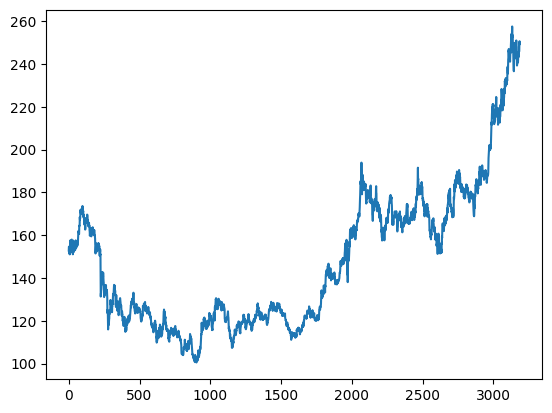

In [ ]:
plt.plot(data_test_yf[0])

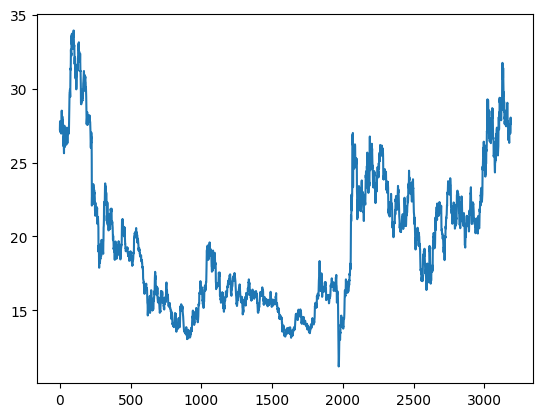

In [ ]:
plt.plot(data_test_yf[1])

<ipython-input-11-96e6a3c9a255>:141: RuntimeWarning: invalid value encountered in sqrt
  self.u_threshold = mu + a_star * sigma / np.sqrt(2 * theta)
<ipython-input-11-96e6a3c9a255>:142: RuntimeWarning: invalid value encountered in sqrt
  self.l_threshold = mu - a_star * sigma / np.sqrt(2 * theta)


<Axes: >

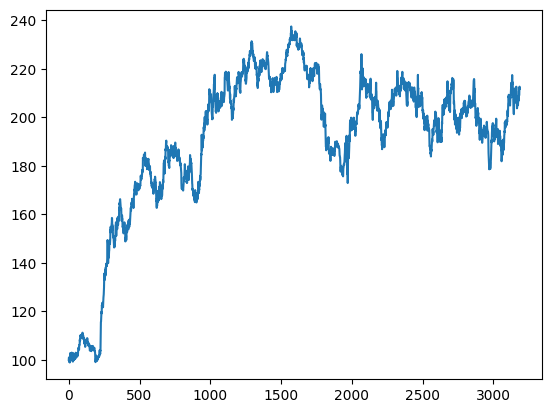

In [ ]:
test_result = test(20,1500)
test_result['Capital'].plot()

<Axes: >

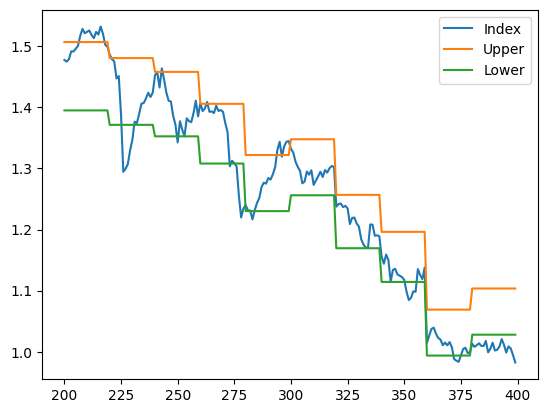

In [ ]:
test_result.iloc[200:400][['Index','Upper','Lower']].plot()

In [ ]:
test_result[test_result.Signal]

,Capital,A,B,AmountA,AmountB,Upper,Lower,Index,Signal,Side
0,99.993000,93.727144,6.265856,0.613398,0.230024,1.745587,1.590266,1.567285,True,True
207,101.405249,95.309711,6.102538,0.608617,0.244664,1.506811,1.394937,1.517145,True,False
226,114.620931,109.959123,4.668807,0.817997,0.326381,1.480595,1.371324,1.294428,True,True
243,123.405432,119.079797,4.332635,0.813317,0.326140,1.457984,1.352492,1.463663,True,False
250,132.108145,128.343472,3.771674,0.945985,0.379340,1.457984,1.352492,1.342605,True,True
260,137.034275,133.489618,3.551657,0.940539,0.393145,1.405725,1.307985,1.406916,True,False
273,147.993260,145.631970,2.368289,1.125172,0.470322,1.405725,1.307985,1.303440,True,True
294,153.512900,151.527869,1.992031,1.121138,0.458546,1.321910,1.230088,1.330352,True,False
351,159.122560,156.651471,2.478089,1.202457,0.465351,1.196175,1.114169,1.098425,True,True
454,166.211925,163.373209,2.845716,1.199069,0.523993,0.912146,0.849997,0.918008,True,False


<Axes: >

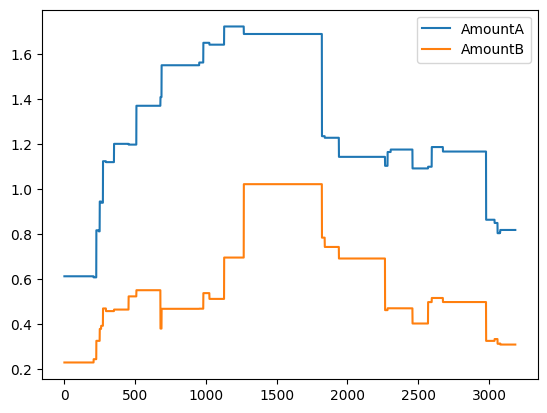

In [ ]:
test_result[['AmountA','AmountB']].plot()

In [ ]:
def calculate_annret_annvol(test_result, initial_capital):

    capital = test_result['Capital']
    daily_returns = capital.pct_change().dropna()

    total_return = (capital.iloc[-1] / initial_capital) - 1
    annualized_return = (1 + total_return) ** (252 / len(daily_returns)) - 1

    annualized_volatility = daily_returns.std() * np.sqrt(252)

    return {
        "Annualized Return": f"{annualized_return * 100:.4f}%",
        "Annualized Volatility": f"{annualized_volatility * 100:.4f}%"
    }


In [ ]:
calculate_annret_annvol(test_result,100)

{'Annualized Return': '6.1130%', 'Annualized Volatility': '13.0002%'}

### Tuning

In [ ]:
def ret(interval, window):
    """
    Compute return using NumPy for efficiency.

    Args:
        interval (int): Interval for the test function.
        window (int): Window size for the test function.

    Returns:
        float: The computed return for the given parameters.
    """
    res = test(interval, window)  # Assuming 'test' is defined and returns a structure with 'Capital'
    capital_changes = np.diff(res['Capital']) / res['Capital'][:-1]  # Equivalent to pct_change().dropna()
    return np.prod(1 + capital_changes) - 1


In [ ]:
def vol(interval, window):
    """
    Compute volatility using NumPy for efficiency.

    Args:
        interval (int): Interval for the test function.
        window (int): Window size for the test function.

    Returns:
        float: The computed return for the given parameters.
    """
    res = test(interval, window)  # Assuming 'test' is defined and returns a structure with 'Capital'
    capital_std = np.std(res['Capital'])
    return capital_std


In [ ]:
intervals = np.array([20, 50, 75, 100, 200, 252, 500])
windows = np.array([100,252,500,750,1000,1250,1500])
test_cases = np.array([(i, w) for i in intervals for w in windows if i < w])

Hyperparameters for best returns

In [ ]:
# Calculate results using vectorized computation
results = np.array([(c, ret(*c)) for c in test_cases], dtype=object)

# Find the maximum result
max_index = np.argmax(results[:, 1])  # Get index of the maximum return
max_case, max_value = results[max_index]

print(f"Maximum return is {max_value} for parameters {max_case}")

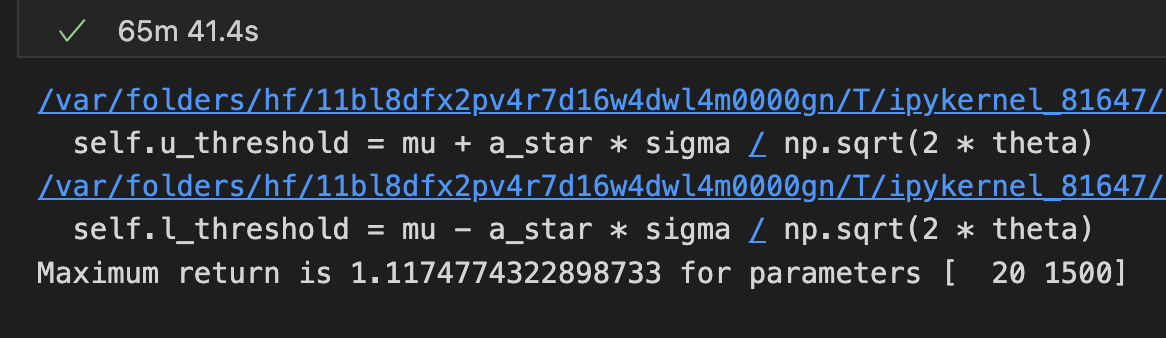

Lowest volatility

In [ ]:
# Calculate results using vectorized computation
results = np.array([(c, vol(*c)) for c in test_cases], dtype=object)

# Find the maximum result
min_index = np.argmin(results[:, 1])  # Get index of the maximum return
min_case, min_value = results[min_index]

print(f"Minimum volatility is {min_value} for parameters {min_case}")

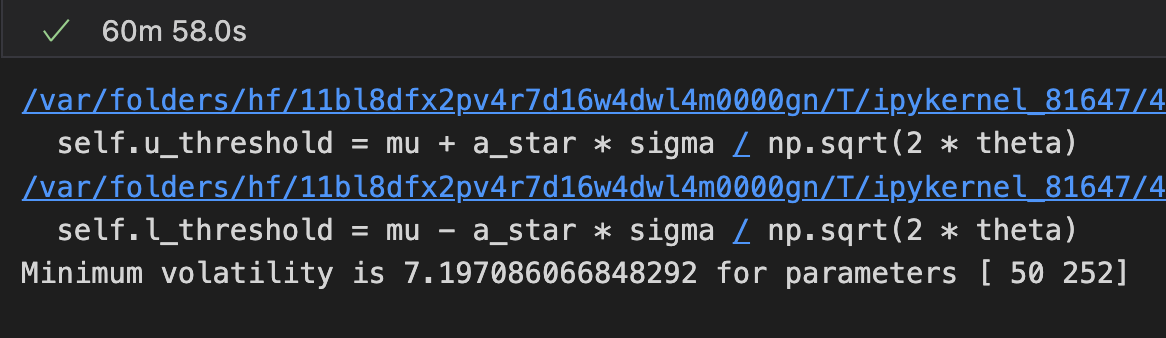

## Market Search

### Alpaca Client

In [ ]:
# my own keys, when not used cautiously, punishment is foreseen :-)
api_key = "PK0WDZ0SZW55U0MT85CC"
secret_key = "5GJTYWOOdmBFums233fGWTfYYBWkSv8R5lxiIVfo"
base_url = 'https://paper-api.alpaca.markets'

trading_client = TradingClient(api_key=api_key, secret_key=secret_key, paper=True, url_override=base_url)
trading_client.get_account()

### Best stock pair search

In [ ]:
def get_1y_data(ticker,api_key,secret_key,test):
    if test:
        request_params = CryptoBarsRequest(
                            symbol_or_symbols=ticker,
                            timeframe=TimeFrame.Day,
                            start=datetime.now().replace(year=datetime.now().day - 10),
                            end=datetime.now().replace(day=datetime.now().day - 1)
                    )
        client = CryptoHistoricalDataClient(api_key,secret_key)
        bars = client.get_crypto_bars(request_params)
        return bars.df
    else:
        request_params = StockBarsRequest(
                        symbol_or_symbols=ticker,
                        timeframe=TimeFrame.Day,
                        start=datetime.now().replace(year=datetime.now().year - 1),
                        end=datetime.now().replace(day=datetime.now().day - 1)
                )
        client = StockHistoricalDataClient(api_key,secret_key)
        bars = client.get_stock_bars(request_params)
        return bars.df


def get_price_data(tickers,api_key,secret_key,test=False):
    data = {ticker: get_1y_data(ticker,api_key,secret_key,test)['close'].to_numpy() for ticker in tickers if 'close' in get_1y_data(ticker,api_key,secret_key,test).columns}
    return data

In [ ]:
def analyze_tickers(price_data,dt):
    tickers = price_data.keys()

    #B/A Ratios to Test
    B_over_A = np.linspace(0.001, 1, 1000)

    #likelihood and param dictionaries
    results = []

    #calc Optimal B and params each pair
    for ticker_1, ticker_2 in combinations(tickers, 2):
        likelihoods = []

        if len(price_data[ticker_1]) != len(price_data[ticker_2]):
            print(f'Not enough data for {ticker_1}-{ticker_2}')
            results.append({
                "t1": ticker_1,
                 "t2": ticker_2,
                "beta": 0,
                "theta": 0,
                "mu": 0,
                 "sigma": 0,
                "likl": 0,
            })
            continue

        #Calculate likelihood for each B/A ratio
        for value in B_over_A:
            alpha = 1 / price_data[ticker_1][0] #calculate the weight of the first asset
            beta = value / price_data[ticker_2][0] #weight of second asset
            spread = alpha * price_data[ticker_1] - beta * price_data[ticker_2] #spread claculation
            parameters = calculate_parameters(spread, dt) # get the ou paprams - theta , mu sigma
            likelihood = log_likelihood(parameters, spread, dt)

            likelihoods.append(likelihood)

        # Find the optimal B for this pair

        ind = np.argmax(likelihoods)
        max_likelihood = likelihoods[ind]
        optimal_B = B_over_A[ind] # get corresponding beta value

        # Recalculate parameters for the optimal B
        alpha = 1 / price_data[ticker_1][0]
        beta = optimal_B / price_data[ticker_2][0]
        spread = alpha * price_data[ticker_1] - beta * price_data[ticker_2]
        mu, theta, sigma = calculate_parameters(spread, dt)

        # Store results
        results.append({
            "t1": ticker_1,
            "t2": ticker_2,
            "beta": optimal_B,
            "theta": theta,
            "mu": mu,
            "sigma": sigma,
            "likl": max_likelihood,
        })
    return sorted(results, key=lambda x: x['likl'],reverse=True)

In [ ]:
search_params = GetAssetsRequest(asset_class=AssetClass.US_EQUITY)
assets = trading_client.get_all_assets(search_params)

symbols = [asset.symbol for asset in assets if asset.tradable and asset.shortable][:10] # remove 10 or increase to get more tickers
print(symbols)

In [ ]:
price_data = get_price_data(symbols,api_key,secret_key)
result = analyze_tickers(price_data,dt)[:10]

for i,out in enumerate(result):
    print(f"{i+1}. {out['t1']}-{out['t2']}: {out['likl']}")

In [ ]:
pair = [result[0]['t1'],result[0]['t2']]

## Real-Time Trading

### Create spread orders

In [ ]:
def close_all():
    trading_client.close_all_positions(cancel_orders=True)

def spread(pair,long=True,qty=None):
    close_all()
    if qty is not None:
        market_order_data = MarketOrderRequest(
                            symbol=pair[0],
                            qty=qty[0],
                            side=OrderSide.BUY if long else OrderSide.SELL,
                            time_in_force=TimeInForce.DAY
                            )

        order1 = trading_client.submit_order(
                        order_data=market_order_data
                    )

        market_order_data = MarketOrderRequest(
                            symbol=pair[1],
                            qty=qty[1],
                            side=OrderSide.SELL if long else OrderSide.BUY,
                            time_in_force=TimeInForce.DAY
                            )

        order2 = trading_client.submit_order(
                        order_data=market_order_data
                    )
    return order1,order2

In [ ]:
account = trading_client.get_account()
model = OU_Trading_Model(int(account.cash))

In [ ]:
window,interval = 100,5
dt_from_start = 0
work_data = {}
status = {}
past_data = []
pair = []

In [ ]:
async def quote_data_handler(data):

    global pair,work_data,dt_from_start,model,status,past_data,trading_client,capital

    tickers = list(work_data.keys())

    if not data.symbol in tickers:
        work_data[data.symbol] = [data.close]
    else:
        work_data[data.symbol].append(data.close)

    status[data.symbol] = True

    print(work_data)

    # if len(tickers) == 2 and len(work_data[tickers[0]]) == len(work_data[tickers[1]]): # First idea

    print(status)
    if len(tickers) == 2 and all(list(status.values())): # Better at handling gaps when streaming data
        n_closes = len(past_data)
        dt_from_start += 1

        prices = [work_data[tickers[0]][-1],work_data[tickers[1]][-1]]
        print(prices)
        past_data.append(prices)

        model.capital = trading_client.get_account().portfolio_value

        if n_closes >= window and dt_from_start % interval == 0:
            print('setup',past_data)
            model.setup(past_data)
        try:
            signal = model.trade(prices)
            if signal:

                orders = spread(pair,model.is_long,[model.amount_a,model.amount_b])
                print(orders)
            print('trade',signal,model.is_long)
        except:
            pass

        for ticker in tickers:
            status[ticker] = False

Disclaimer: won't work in Jupyter notebook

In [ ]:
pair = ['BTC/USDT','SOL/USDT'] # For test
stream = CryptoDataStream(api_key, secret_key)
stream.subscribe_bars(quote_data_handler, *pair)
stream.run()

In [ ]:
stream = StockDataStream(api_key, secret_key)
stream.subscribe_daily_bars(quote_data_handler, *pair)
stream.run()

## Appendix

Other links:
 - https://www.notion.so/team/162e780e-d28e-811d-9676-0042384ed2e8/joinhttps://www.notion.so/team/162e780e-d28e-811d-9676-0042384ed2e8/join - team's Notion page
 - https://github.com/AlphaShk/ou_pair_trading - full model to trade in real time
